In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Presentation
The aim of this notebook is to perform missing values filling on a user table, the user data is given on a file in csv format.
<br>
This file has 5 columns :
<ul>
    <li> yob : Year of birth which is the user birthdate </li>
    <li> domain : which is the domain name of the user address </li>
    <li> first name : whis is the user first name and this column has been encrypted </li>
    <li> zipcode </li>
    <li> gender : which is the user gender</li>
</ul>
The missing values that we consider are on column gender and yob

## Loading data and inspection

In [42]:
file_path = "user_exo_2M.csv"
user_df = pd.read_csv(file_path)
user_df.head()

,yob,domain,firstname,zipcode,gender
0,1985,@wanadoo.fr,b08253b305fb5ec,94450.0,F
1,1961,@sfr.fr,7ff135854376850,78580.0,M
2,1977,@free.fr,172522ec1028ab7,62640.0,NaN
3,-1,@hotmail.com,d3ca5dde60f88db,94100.0,M
4,-1,@gmail.com,bdaae16837dd576,78100.0,NaN


In [43]:
user_df.dtypes

yob            int64
domain        object
firstname     object
zipcode      float64
gender        object
dtype: object

In [44]:
#percentage of missing values for each column
100*user_df.isna().sum()/len(user_df)

yob           0.0000
domain        0.0000
firstname     0.0000
zipcode       0.8597
gender       40.2477
dtype: float64

As we see after this inspection, yob column has no missing values but we can see that we have -1 on some rows which is not a birthdate,  we will replace -1 by NaN.

In [45]:
# We replace -1 by  NaN on column yob
user_df['yob'] = user_df.yob.replace(-1, np.nan)

In [46]:
# percentage of missing values for each column 
100*user_df.isna().sum()/len(user_df)

yob          40.0000
domain        0.0000
firstname     0.0000
zipcode       0.8597
gender       40.2477
dtype: float64

In [47]:
first_name_unique_ratio = 100*len(user_df.firstname.unique())/len(user_df)
print(f"The percentage of unique first name on the dataset is {first_name_unique_ratio}%")

The percentage of unique first name on the dataset is 0.7841%


In [48]:
user_df['firstname'].value_counts()

deb97a759ee7b8b    17086
b22c8efc9455118    16975
9a6663f1bf0c560    16374
60784186ea5b29f    15319
4757067ca131abf    14532
                   ...  
6940c723f90d2db        1
42b438a4533d22d        1
42337fc92bd9ac9        1
3ffe44ae3556e02        1
6824cc4c7c33aab        1
Name: firstname, Length: 15682, dtype: int64

### Filling gender missing values
#### Methodology
as we can see the set of unique first name represent 0.78% of the global user table data. 
<br>
We will fill the gender missing values by using the following strategy :
<br>
 <ul>
    <li>For each missing gender row we will look at his firstname column </li>
     <li>If his first name has only one occurence on the global data, we will replace his gender by the mode of the part of the global data which has no missing gender value.</li>
     <li> If his first name has many occurences, we will replace this missing gender value by the mode of the corresponding data which has the corresponding firstname.</li>
    </ul>
    
 
!!!!! Another possible approach is to use a model trained to predict the gender based on an embedding of the firstname but we think that we should have others features as the yob by example to do it.
   
  

In [49]:
# The mode of the gender serie
gender_mode = user_df['gender'].mode()
print(gender_mode)

0    M
dtype: object


In [50]:
gender_notna_df = user_df[~user_df.gender.isna()].copy() # the data with no missing gender value
gender_na_df =  user_df[user_df.gender.isna()].copy() # the data with missing gender value
gender_notna_df['count'] = [1 for i in range(len(gender_notna_df))] # we store the occurence of each firstname

gender_notna_pivot = pd.pivot_table(gender_notna_df, values='count', index=['firstname'],
                      columns=['gender'], aggfunc=np.sum)
gender_notna_pivot = gender_notna_pivot.fillna(0)
gender_notna_df = gender_notna_df.drop('count', axis=1)
gender_notna_pivot.head()

gender,F,M
firstname,,
0002d7397fcbcc8,5.0,1.0
001905a757375ad,6.0,1.0
0025e89702ab006,3.0,1.0
00261e88ea74565,3.0,1.0
0029b2820a9d594,6.0,1.0


In [51]:
# For each first name we have the mode of gender
temp = gender_notna_pivot.idxmax(axis=1)
temp2 = pd.DataFrame({"gender_fill":temp}).reset_index()
temp2.head()

,firstname,gender_fill
0,0002d7397fcbcc8,F
1,001905a757375ad,F
2,0025e89702ab006,F
3,00261e88ea74565,F
4,0029b2820a9d594,F


In [52]:
#We check if all the firstnames of gender_na_df are present in gender_notna_df
notna = temp.index
na = gender_na_df.firstname.unique()
check_list =  [x for x in na if x not in notna]
# if check_list is empty (len(check_list) = 0),  so all the names in gender_na_df are present in gender_notna_df
print(len(check_list)==0)

False


In [53]:
print(len(check_list))

461


As we see all the first names present in gender_na_df are not present  in gender_na_df so we can fill the missing gender by using the majority classifier given by temp

In [54]:
gender_na_fill = pd.merge(gender_na_df, temp2, how='left', on='firstname')
gender_na_fill['gender'] = gender_na_fill['gender_fill'].fillna('M') # the gender mode is 'M'
user_df2 = gender_notna_df.append(gender_na_fill.drop("gender_fill", axis=1))

In [55]:
user_df2.head()

,yob,domain,firstname,zipcode,gender
0,1985.0,@wanadoo.fr,b08253b305fb5ec,94450.0,F
1,1961.0,@sfr.fr,7ff135854376850,78580.0,M
3,NaN,@hotmail.com,d3ca5dde60f88db,94100.0,M
5,1975.0,@wanadoo.fr,57c2877c1d84c4b,92600.0,M
6,1974.0,@gmail.com,d47de916cacd0b7,65200.0,M


In [56]:
# percentage of missing values for each column of user_df2
100*user_df2.isna().sum()/len(user_df2)

yob          40.0000
domain        0.0000
firstname     0.0000
zipcode       0.8597
gender        0.0000
dtype: float64

## Filling year of birth missing values

In the following lines we will work with  the dataframe user_df2 

In [57]:
# We inspect all the domain names
print(user_df2.domain.unique())

['@wanadoo.fr' '@sfr.fr' '@hotmail.com' '@gmail.com' '@live.fr'
 '@yahoo.fr' '@free.fr' '@orange.fr' '@aol.com' '@hotmail.fr'
 '@libertysurf.fr' '@aliceadsl.fr' '@laposte.net' '@ebuyclub.com'
 '@numericable.fr' '@club-internet.fr' '@dbmail.com' '@9online.fr'
 '@yahoo.com' '@neuf.fr' '@netcourrier.com' '@voila.fr' '@nordnet.fr'
 '@bbox.fr' '@outlook.fr' '@cegetel.net' '@msn.com' '@noos.fr'
 '@outlook.com' '@me.com' '@aol.fr' '@gmx.fr' '@ymail.com' '@gmx.com'
 '@icloud.com' '@live.com' '@live.be' '@bluewin.ch' '@gmail.fr'
 '@skynet.be' '@mail.ru' '@hotmail.be' '@limonetik10.com']


In [58]:
# In this part we will see how the data are distributed by domain name for each year of birth
yob_not_na_df = user_df2[~user_df2.yob.isna()].copy()
yob_na_df = user_df2[user_df2.yob.isna()].copy()
yob_not_na_df['count'] = [1 for x in range(len(yob_not_na_df))]
domain_yob_df = pd.pivot_table(yob_not_na_df, values='count', index=['domain'],
                      columns=['yob'], aggfunc=np.sum)
domain_yob_df = domain_yob_df.fillna(0)
yob_not_na_df = yob_not_na_df.drop('count', axis=1)
domain_yob_df.head()

yob,1900.0,1901.0,1902.0,1910.0,1911.0,1920.0,1922.0,1923.0,1924.0,1925.0,...,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0
domain,,,,,,,,,,,,,,,,,,,,,
@9online.fr,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,4.0,5.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
@aliceadsl.fr,13.0,1.0,5.0,2.0,0.0,2.0,1.0,0.0,1.0,0.0,...,24.0,13.0,17.0,9.0,11.0,10.0,13.0,6.0,4.0,6.0
@aol.com,30.0,2.0,4.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,...,71.0,70.0,51.0,48.0,28.0,39.0,33.0,14.0,11.0,9.0
@aol.fr,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.0,32.0,17.0,20.0,22.0,25.0,14.0,15.0,8.0,7.0
@bbox.fr,17.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,93.0,86.0,65.0,55.0,53.0,54.0,38.0,40.0,14.0,5.0


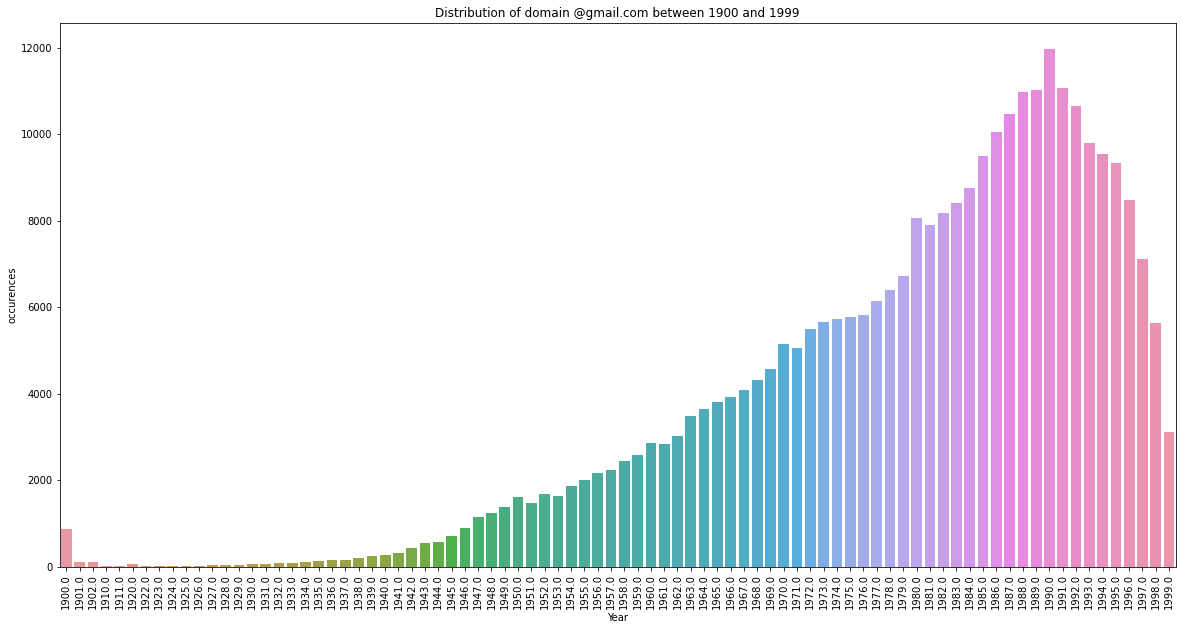

In [59]:
# Example of plot for the domain @gmail.com
plt.figure(figsize=(20, 10))
ax  = sns.barplot( list(domain_yob_df.loc['@gmail.com'].index),  list(domain_yob_df.loc['@gmail.com']))
plt.title('Distribution of domain @gmail.com between 1900 and 1999')
plt.xlabel('Year')
plt.ylabel('occurences')
ax.tick_params(axis='x', rotation=90)


### Methodology
We see that the domain name is distributed over the year of birth so to fill the missing yob values we will use this specific column and use the following process :
<ul>
    <li>
        We will group data by domain on the dataframe yob_not_na_df and compute the median for the column yob, this dataframe is called domain_yob_median.
    </li>
    <li>
        In the dataframe yob_na_df, each missing yob will be fill with the median yob associated to his domain name
        ff this domain is present in domain_yob_median <br>else we will  fill the yob with yob_median(median of yob column on the dataframe user_df2)
    </li>
</ul>

!!!!! As estimator of the yob we can also use the mean (or weighted mean) but we see that for a given domain name we have many occurences and a few in others years in some years so we think that the median is better here 


In [60]:
# the yob median
yob_median =yob_not_na_df.yob.median()
print(yob_median)

1979.0


In [61]:
domain_yob_median =  yob_not_na_df.groupby('domain').agg({"yob":np.median})
domain_yob_median.head()

,yob
domain,
@9online.fr,1965.0
@aliceadsl.fr,1968.0
@aol.com,1967.0
@aol.fr,1977.0
@bbox.fr,1970.0


In [62]:
#We check if all the domain of yob_na_df are present in yob_notna_df
domain_notna = domain_yob_median.index
domain_na = yob_na_df.domain.unique()
check_list2 =  [x for x in domain_na if x not in domain_notna]
# if check_list2 is empty (len(check_list2) = 0),  so all the domains in yob_na_df are present in yob_notna_df
print(len(check_list2)==0)

True


As we see all the domain names present in domain_na are present in domain_notna so we can fill the missing values by using domain_yob_median directly

In [63]:
yob_na_fill = pd.merge(yob_na_df[['domain', 'firstname', 'zipcode', 'gender']], domain_yob_median, on='domain', how='left')
# The resulting data frame with yob and gender filled
user_df3 = yob_not_na_df.append(yob_na_fill)
user_df3.head()

,yob,domain,firstname,zipcode,gender
0,1985.0,@wanadoo.fr,b08253b305fb5ec,94450.0,F
1,1961.0,@sfr.fr,7ff135854376850,78580.0,M
5,1975.0,@wanadoo.fr,57c2877c1d84c4b,92600.0,M
6,1974.0,@gmail.com,d47de916cacd0b7,65200.0,M
10,1961.0,@gmail.com,aa47f8215c6f30a,67380.0,M


In [64]:
# percentage of missing values for each column 
100*user_df3.isna().sum()/len(user_df3)

yob          0.0000
domain       0.0000
firstname    0.0000
zipcode      0.8597
gender       0.0000
dtype: float64

In [65]:
user_df3.to_csv("user_completed.csv", index=False)